In [1]:
import os
os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
os.getcwd()

'C:\\Users\\emrijai\\Documents\\IPython Notebooks\\MS7331\\Project1\\MSDS7331_Project1'

In [2]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'mths_since_last_major_derog', 'desc', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt', 'out_prncp']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data (used for new data frames)
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

#Impute missing data values with median
for col in ['total_acc']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp    

for col in ['total_pymnt']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp 
   

tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1)

if 'purpose' in loan_df:
    del loan_df['purpose']
    

loan_df = loan_df.dropna()

from datetime import datetime
loan_df['duration_paid'] =  (pd.to_datetime(loan_df['last_pymnt_d']) - pd.to_datetime(loan_df['issue_d']))

loan_df['Count_Days'] =  loan_df['duration_paid'].dt.days
loan_df['Payment_rate'] =  loan_df['total_pymnt'] / (loan_df['Count_Days']+1)*30
loan_df['Payment_ratio'] = loan_df['Payment_rate']/ loan_df['installment']

loan_df = loan_df.dropna()

if "issue_d" in loan_df:
    del loan_df["issue_d"]
if "last_pymnt_d" in loan_df:
    del loan_df["last_pymnt_d"]
if "total_pymnt" in loan_df:
    del loan_df["total_pymnt"]
if "duration_paid" in loan_df:
    del loan_df["duration_paid"]
if "Count_Days" in loan_df:
    del loan_df['Count_Days']
    
# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans

#loan_df.copy()

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]
    
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869720 entries, 0 to 887378
Data columns (total 54 columns):
funded_amnt                        869720 non-null float64
term                               869720 non-null int64
installment                        869720 non-null float64
annual_inc                         869720 non-null float64
dti                                869720 non-null float64
delinq_2yrs                        869720 non-null float64
inq_last_6mths                     869720 non-null float64
open_acc                           869720 non-null float64
total_acc                          869720 non-null float64
acc_now_delinq                     869720 non-null float64
grade_A                            869720 non-null float64
grade_B                            869720 non-null float64
grade_C                            869720 non-null float64
grade_D                            869720 non-null float64
grade_E                            869720 non-null float64
grade_

In [3]:
from sklearn.cross_validation import ShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from matplotlib import pyplot as plt


# Split our data frame into our classification of Loan_Class and the rest of the data set
if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values

Additionally we created a small data set 'subsampled_df' to test multiple algorithms using Gridsearch and Pipelining in order to find the best combination of the parameters set and/or Average Voting of all best possible algorithms together.

In [4]:
# Add column to determine if loan is good or bad based on classification in data set
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)


import pandas
# Randomly sample X% of your dataframe for future use (We will use small subset of data for SVM (Batch) classification)
subsampled_df = loan_df_finished.copy().sample(frac=0.01)

#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]
    
#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in subsampled_df:
    del subsampled_df["Loan_Class"]
if "Loan_Class2" in subsampled_df:
    del subsampled_df["Loan_Class2"]

In [5]:
# Split the data into our x and y matrices for testing
if 'isGoodLoan' in subsampled_df:
    updated_subsampled_y = subsampled_df['isGoodLoan'].values
    del subsampled_df['isGoodLoan']
    updated_subsampled_X = subsampled_df.values

# Create a new Shuffle split on the narrowed classification data
num_cv_iterations = 5
num_instances = len(updated_subsampled_y)
updated_cv_obj_subsampled = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)
print updated_subsampled_X.shape
print updated_subsampled_y.size

(2702L, 53L)
2702


### GridSearch and Optimization/Parallelization

Since our dataset consists of very large amount of recodrs running on a laptop takes very long. in order to compare the various algorithms and extract the best parameter set for these algorithms we are using smaller 'subsampled_df' dataset.  
Split the 'subsampled_df' data into our x and y matrices for testing the performance of multiple algorithms against each other.

In [6]:
from sklearn.cross_validation import train_test_split

X_train_updated, X_test_updated, y_train_updated, y_test_updated = \
train_test_split(updated_subsampled_X,updated_subsampled_y, test_size = 0.2, random_state = 1)

In the next section we are running multiple algorithms together using pipelining  and comparing their ROC and Precision. We are more interested in precision as our we want to classify and predict the defaulters so that the company can take necessary actions and prevent potential loss in the future

In [7]:
warnings.simplefilter("ignore")
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.0001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=0)
clf3 = RandomForestClassifier(n_estimators=20, random_state=0)
clf4 = AdaBoostClassifier(clf3, algorithm="SAMME", n_estimators=50)
clf5 = SVC(kernel = 'linear', C=10, probability=True)
clf6 = SGDClassifier(alpha=0.0001,fit_intercept=True, l1_ratio=1.0, learning_rate='optimal', 
                     penalty='L2', loss='modified_huber')
clf7 = KNeighborsClassifier(n_neighbors=4)
clf8 = AdaBoostClassifier(clf2, algorithm="SAMME", n_estimators=50)

pipe1 = Pipeline([['sc', StandardScaler()],['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()],['clf', clf2]])
pipe3 = Pipeline([['sc', StandardScaler()],['clf', clf3]])
pipe4 = Pipeline([['sc', StandardScaler()],['clf', clf4]])
pipe5 = Pipeline([['sc', StandardScaler()],['clf', clf5]])
pipe6 = Pipeline([['sc', StandardScaler()],['clf', clf6]])
pipe7 = Pipeline([['sc', StandardScaler()],['clf', clf7]])
pipe8 = Pipeline([['sc', StandardScaler()],['clf', clf8]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forests', 
              'AdaBoost_RandomForests', 'Batch-SVM', 'SGD-SVM', 'KNN', 'AdaBoost_DecisionTrees' ]

print('K-fold cross validation:\n')


all_clf = [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6, pipe7, pipe8]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train_updated, y=y_train_updated, cv=5, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    scores = cross_val_score(estimator=clf, X=X_train_updated, y=y_train_updated, cv=3, scoring='precision')
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    scores = cross_val_score(estimator=clf, X=X_train_updated, y=y_train_updated, cv=3, scoring='recall')
    print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    scores = cross_val_score(estimator=clf, X=X_train_updated, y=y_train_updated, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    print ('-------')


K-fold cross validation:

ROC AUC: 0.70 (+/- 0.04) [Logistic Regression]
Precision: 0.82 (+/- 0.00) [Logistic Regression]
Recall: 0.85 (+/- 0.03) [Logistic Regression]
Accuracy: 0.74 (+/- 0.02) [Logistic Regression]
-------
ROC AUC: 0.90 (+/- 0.02) [Decision Tree]
Precision: 0.90 (+/- 0.01) [Decision Tree]
Recall: 0.98 (+/- 0.00) [Decision Tree]
Accuracy: 0.89 (+/- 0.01) [Decision Tree]
-------
ROC AUC: 0.89 (+/- 0.03) [Random Forests]
Precision: 0.89 (+/- 0.01) [Random Forests]
Recall: 0.95 (+/- 0.00) [Random Forests]
Accuracy: 0.87 (+/- 0.01) [Random Forests]
-------
ROC AUC: 0.83 (+/- 0.01) [AdaBoost_RandomForests]
Precision: 0.88 (+/- 0.01) [AdaBoost_RandomForests]
Recall: 0.96 (+/- 0.01) [AdaBoost_RandomForests]
Accuracy: 0.86 (+/- 0.00) [AdaBoost_RandomForests]
-------
ROC AUC: 0.87 (+/- 0.02) [Batch-SVM]
Precision: 0.83 (+/- 0.00) [Batch-SVM]
Recall: 0.97 (+/- 0.01) [Batch-SVM]
Accuracy: 0.82 (+/- 0.01) [Batch-SVM]
-------
ROC AUC: 0.62 (+/- 0.04) [SGD-SVM]
Precision: 0.80 (+/- 

We can print the ROC-AUC to see the performance of each algorithms on the test data set individually. This presents a visual reprasentation of which algorithms are doing how well on the test data set and hence can be used for further algorithm selection and optimization

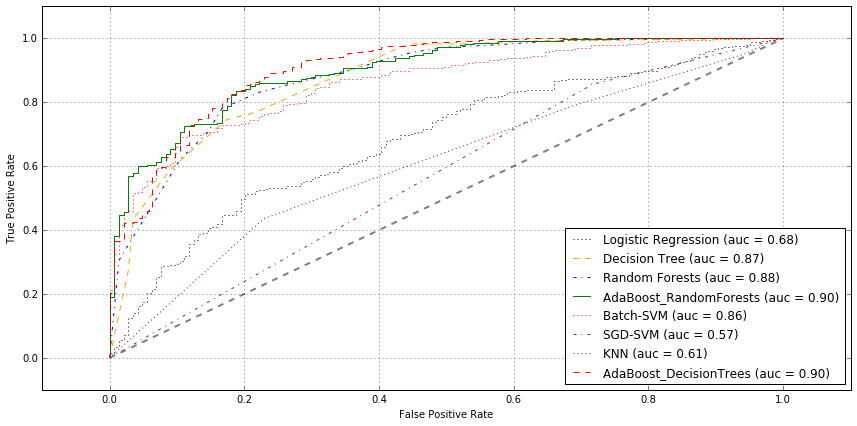

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
colors = ['black', 'orange', 'blue', 'green', 'red', 'brown', 'purple', 'red']
linestyles = [':', '--', '-.', '-', ':', '-.', ':', '--']
for clf, label, clr, ls \
        in zip(all_clf, 
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train_updated, 
                     y_train_updated).predict_proba(X_test_updated)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test_updated, 
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

As we can see from the above ROC-AUC chart, desicion tree, random forests and adaboost all perform pretty well on this data set. Adaboost with Decision trees has the highest Precision, Accuracy and ROC-AUC

Next we will parallelize all these algorithms and run a VotingClassifier. the idea of the algorithm is that it allows us to combine different classification algorithms associated with individual weights for confidence. Our goal is to build a stronger meta-classifier that balances out the individual classifiers' weaknesses on a particular dataset.

We will use GridSearch for this task to extract out the best parameters for specific estimator/classification algorithms. By this method we can run multiple iterations and pick the best parameter set that gives us the highest metric scopre for example 'Precision ' in our case.

In [9]:
from sklearn.ensemble import VotingClassifier
from sklearn.grid_search import GridSearchCV

eclf2 = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('rf', pipe3), ('adarf', pipe4), ('adadt', pipe8)], voting='soft')
params = {'lr__clf__C': [100, 0.1, 0.0001], 'lr__clf__penalty': ['l2'], 'dt__clf__max_depth': [3, 5], 'rf__clf__n_estimators':[20, 50], 'adarf__clf__n_estimators': [20, 50], 'adadt__clf__n_estimators': [20, 50]}
#params = {'lr__clf__C': [0.001, 0.0001]}
#params = {'lr__clf__C': [0.0001], 'lr__clf__penalty': ['l1'], 'dt__clf__max_depth': [5], 'rf__clf__n_estimators':[20], 'ada__clf__n_estimators': [20], 'ada__clf__algorithm': ['SAMME']}

#eclf2 = eclf2.fit(X, y)

grid = GridSearchCV(estimator=eclf2, param_grid=params, cv=5, scoring='precision')
grid = grid.fit(X_train_updated, y_train_updated)


In [10]:
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, scores.std() / 2, params))

0.876+/-0.00 {'adadt__clf__n_estimators': 20, 'adarf__clf__n_estimators': 20, 'dt__clf__max_depth': 3, 'lr__clf__penalty': 'l2', 'rf__clf__n_estimators': 20, 'lr__clf__C': 100}
0.879+/-0.00 {'adadt__clf__n_estimators': 20, 'adarf__clf__n_estimators': 20, 'dt__clf__max_depth': 3, 'lr__clf__penalty': 'l2', 'rf__clf__n_estimators': 50, 'lr__clf__C': 100}
0.860+/-0.00 {'adadt__clf__n_estimators': 20, 'adarf__clf__n_estimators': 20, 'dt__clf__max_depth': 3, 'lr__clf__penalty': 'l2', 'rf__clf__n_estimators': 20, 'lr__clf__C': 0.1}
0.861+/-0.00 {'adadt__clf__n_estimators': 20, 'adarf__clf__n_estimators': 20, 'dt__clf__max_depth': 3, 'lr__clf__penalty': 'l2', 'rf__clf__n_estimators': 50, 'lr__clf__C': 0.1}
0.875+/-0.01 {'adadt__clf__n_estimators': 20, 'adarf__clf__n_estimators': 20, 'dt__clf__max_depth': 3, 'lr__clf__penalty': 'l2', 'rf__clf__n_estimators': 20, 'lr__clf__C': 0.0001}
0.878+/-0.00 {'adadt__clf__n_estimators': 20, 'adarf__clf__n_estimators': 20, 'dt__clf__max_depth': 3, 'lr__clf_

In [11]:
clf = grid.best_estimator_
clf.fit(X_train_updated,y_train_updated)
print ('Best Estimator: %s' % clf)
print ('======================')
print ('Test Accuracy: %.3f' % clf.score(X_test_updated, y_test_updated))

Best Estimator: VotingClassifier(estimators=[('lr', Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, ...dom_state=0, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)]]))],
         voting='soft', weights=None)
Test Accuracy: 0.861


In [12]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'adadt__clf__n_estimators': 50, 'adarf__clf__n_estimators': 50, 'dt__clf__max_depth': 5, 'lr__clf__penalty': 'l2', 'rf__clf__n_estimators': 20, 'lr__clf__C': 100}
Accuracy: 0.89
